In [1]:
from pathlib import Path
import json
import copy
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['figure.figsize'] = (10, 7)

columnname2colour = {"FASPR":"red","FASPR 0":"red", "FASPR 1":"red", "FASPR 10":"black","PSF":"black","PSF 0":"black","PSF 1":"black","PSF 10":"red"}

def read_ost_scores(path:Path) -> dict:
    with open(path, "r") as json_file:
        read_json = json.load(json_file)
    if read_json["status"]=="FAILURE":
        return None
    output = {"lddt": read_json["lddt"], "ost_rmsd": read_json["rmsd"], "tm_score": read_json["tm_score"]}
    return output

table = []
for faspr_path in [Path("CASP14_FASPR")]:
    for file_id in sorted(faspr_path.glob("*")):
        file_id = str(file_id).split("/")[1]
        curr_row = {"file_id":file_id}
        # FASPR
        faspr_ost_scores = read_ost_scores(faspr_path/f"{file_id}/ost_scores.json")
        if faspr_ost_scores is None:
            continue
        faspr_row = copy.copy(curr_row)
        faspr_row.update({"recycle":"FASPR"})
        with open(faspr_path/f"{file_id}/attn_scores.json", "r") as json_file:
            faspr_row.update(json.load(json_file))
            faspr_row.update(faspr_ost_scores)
        table.append(faspr_row)
        #PSF
        psf_path = Path(str(faspr_path)[:-5]+"BB_PSF")
        psf_ost_scores = read_ost_scores(psf_path/f"{file_id}/ost_scores.json")
        if psf_ost_scores is None:
            continue
        psf_row = copy.copy(curr_row)
        psf_row.update({"recycle":"PSF"})
        with open(psf_path/f"{file_id}/attn_scores.json", "r") as json_file:
            psf_row.update(json.load(json_file))
            psf_row.update(psf_ost_scores)
        table.append(psf_row)
        # PSF AlphaFold
        for recycle in ["0","1","10"]:
            recycle_row = copy.copy(curr_row)
            recycle_row.update({"recycle":f"PSF {recycle}"})
            recycle_ost_scores = read_ost_scores(Path(str(faspr_path)[:-5]+"PSF_AF" )/f"{file_id}/ost_scores{recycle}.json")
            with open(Path(str(faspr_path)[:-5]+"PSF_AF" )/f"{file_id}/attn_scores{recycle}.json", "r") as json_file:
                recycle_row.update(recycle_ost_scores)
                recycle_row.update(json.load(json_file))
            table.append(recycle_row)
        # FASPR AlphaFold
        for recycle in ["0","1","10"]:
            recycle_row = copy.copy(curr_row)
            recycle_row.update({"recycle":f"FASPR {recycle}"})
            recycle_ost_scores = read_ost_scores(Path(str(faspr_path)[:-5]+"AF" )/f"{file_id}/ost_scores{recycle}.json")
            with open(faspr_path/f"{file_id}/attn_scores{recycle}.json", "r") as json_file:
                recycle_row.update(recycle_ost_scores)
                recycle_row.update(json.load(json_file))
            table.append(recycle_row)
        for recycle in ["0","1","10"]:
            recycle_row = copy.copy(curr_row)
            recycle_row.update({"recycle":"BB "+recycle})
            recycle_ost_scores = read_ost_scores(Path(str(faspr_path)[:-5]+"BB_AF" )/f"{file_id}/ost_scores{recycle}.json")
            with open(faspr_path/f"{file_id}/attn_scores{recycle}.json", "r") as json_file:
                recycle_row.update(recycle_ost_scores)
                recycle_row.update(json.load(json_file))
            table.append(recycle_row)
df = pd.DataFrame(table)
os.makedirs("tables", exist_ok=True)
df.to_csv("tables/packing.csv")
df

,file_id,recycle,rmsd,mae_1,mae_2,mae_3,mae_4,acc,lddt,ost_rmsd,tm_score
0,T1025,FASPR,0.844302,21.841581,21.990368,46.709343,54.993057,0.600000,0.930854,3.257462e-06,1.000000
1,T1025,PSF,1.998496,73.589340,32.415726,55.502621,58.391724,0.210526,0.861394,3.257462e-06,1.000000
2,T1025,PSF 0,0.736193,20.212498,21.122366,44.131413,65.524361,0.626316,0.934178,4.911972e-01,0.954706
3,T1025,PSF 1,0.698177,18.457880,20.240631,41.715275,62.815571,0.642105,0.933041,4.869693e-01,0.954675
4,T1025,PSF 10,0.701757,18.893194,20.473053,40.712883,56.187988,0.642105,0.918292,4.917052e-01,0.954502
5,T1025,FASPR 0,0.649228,14.137197,19.168890,45.359375,64.677719,0.647368,0.943007,4.710899e-01,0.955467
6,T1025,FASPR 1,0.668199,15.284217,19.595356,48.766617,65.473572,0.657895,0.935087,4.716445e-01,0.955485
7,T1025,FASPR 10,0.661363,15.851188,19.065096,50.236774,58.833111,0.657895,0.938872,4.709491e-01,0.955438
8,T1025,BB 0,0.649228,14.137197,19.168890,45.359375,64.677719,0.647368,0.590842,2.092045e+01,0.369822
9,T1025,BB 1,0.668199,15.284217,19.595356,48.766617,65.473572,0.657895,0.714094,8.506090e+00,0.708764


In [2]:
class Radar(object):
    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]
        self.n = len(titles)
        self.angles = [a if a <=360. else a - 360. for a in np.arange(90, 90+360, 360.0/self.n)]
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=25, weight="normal", color="black")

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            self.ax.yaxis.grid(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids([0.2,0.4,0.6,0.8,1], labels=label, angle=angle, fontsize=20)
            ax.grid(linewidth=0.1)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 1.1)  
            ax.xaxis.grid(True,color='black',linestyle='-', linewidth=0.5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, linewidth=4.0, *args, **kw)

In [3]:
dft = df.groupby("recycle").agg("mean").transpose()
dft

recycle,BB 0,BB 1,BB 10,FASPR,FASPR 0,FASPR 1,FASPR 10,PSF,PSF 0,PSF 1,PSF 10
rmsd,0.944158,0.940469,0.946026,1.019473,0.944158,0.940469,0.946026,2.036574,1.014876,0.994878,0.993400
mae_1,29.140359,29.201344,29.432127,31.385694,29.140359,29.201344,29.432127,76.393057,32.136575,31.523708,31.677127
mae_2,28.426760,28.283071,28.447971,30.974428,28.426760,28.283071,28.447971,37.745892,29.579875,29.294848,29.214108
mae_3,46.364924,46.309960,46.628763,48.657047,46.364924,46.309960,46.628763,56.006335,47.934843,47.540728,46.914863
mae_4,50.436805,50.331493,50.355200,55.125228,50.436805,50.331493,50.355200,50.170805,49.343173,49.403338,49.475413
acc,0.517398,0.517690,0.513178,0.487324,0.517398,0.517690,0.513178,0.183822,0.483266,0.487675,0.486949
lddt,0.517964,0.523247,0.520346,0.902802,0.852794,0.848998,0.843603,0.830370,0.835989,0.831444,0.827690
ost_rmsd,19.628616,17.988901,15.833900,0.000006,1.146459,1.244940,1.108640,0.000006,1.337761,1.361647,1.355346
tm_score,0.378635,0.410904,0.463396,1.000000,0.887162,0.885189,0.888354,1.000000,0.880983,0.877911,0.877339


In [5]:
cut_df = dft.loc[["tm_score", "rmsd", "acc", "mae_4","mae_3","mae_2","mae_1"]]
fig = plt.figure(figsize=(10, 10))
titles = ["TM-Score", "Side-chain RMSD","Accuracy","$\chi_4$","$\chi_3$","$\chi_2$","$\chi_1$"]
starts = np.array([0.87,2,0.15,55.5,56,38,75])
ends = np.array([1,0.95,0.5,49.5,46,28,30])
zeros = ends-(ends-starts)/0.8
labels = [[str(elem),"","","",str(ends[i])] for i, elem in enumerate(starts)]

<Figure size 1000x1000 with 0 Axes>

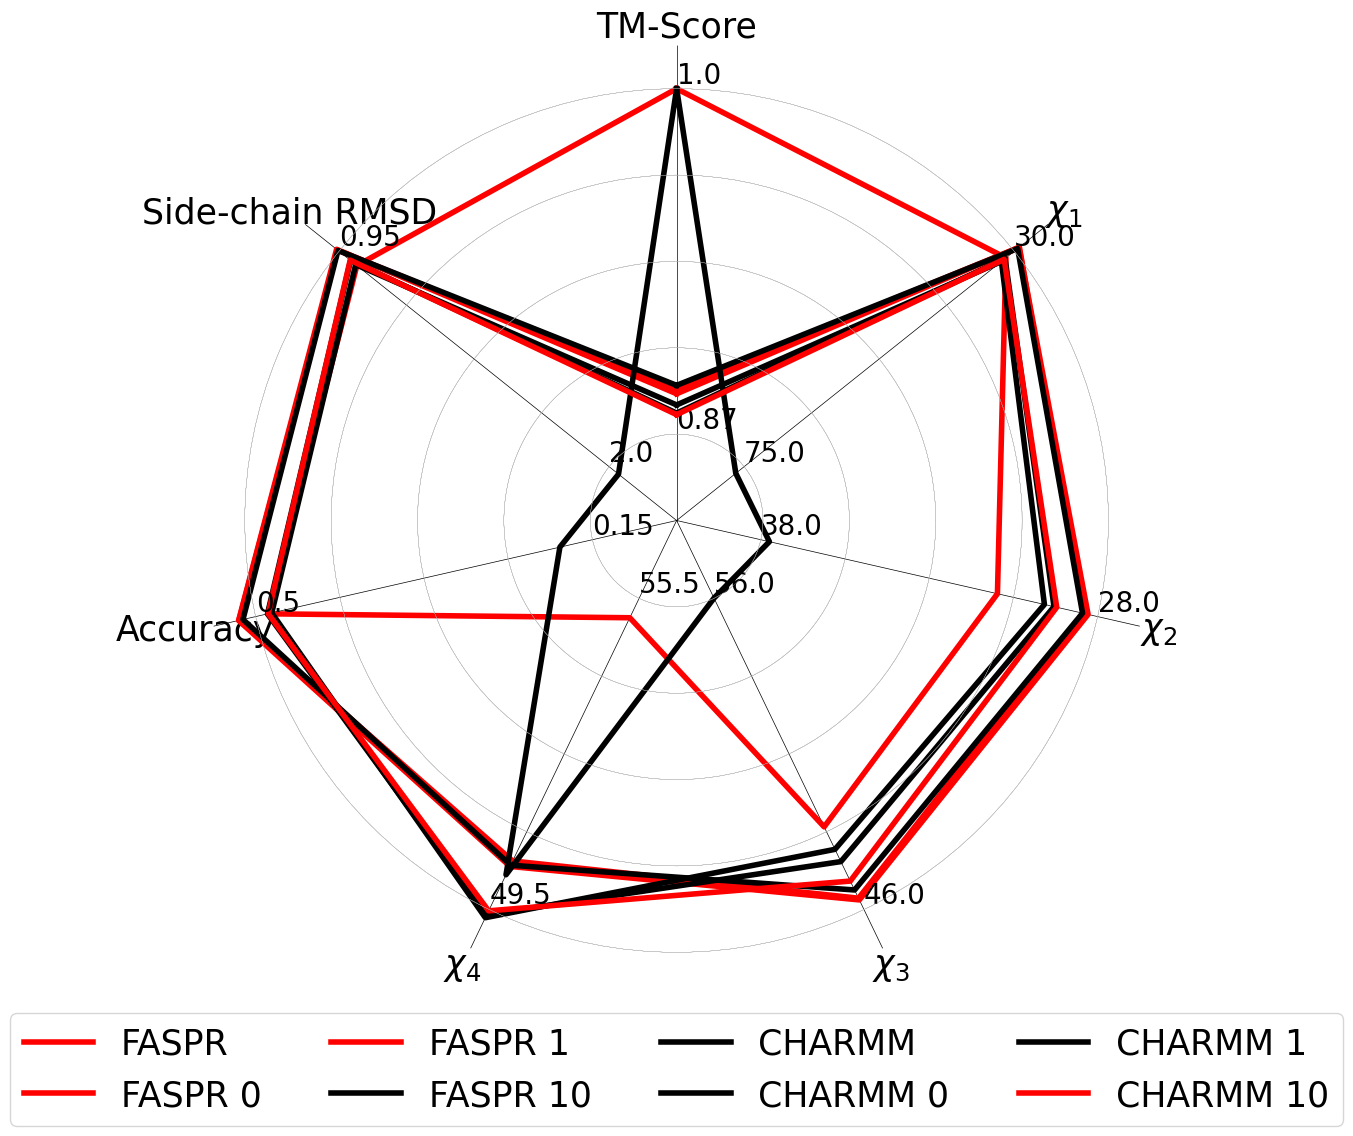

In [6]:
fig = plt.figure(figsize=(10, 10))
radar = Radar(fig, titles, labels)
for columnname in cut_df.columns:
    if "BB" in columnname:
        continue
    values = (cut_df[columnname]-zeros)/(ends-zeros)
# draw the polygon and the mark the points for each angle/value combination
    radar.plot(values, label=columnname.replace("PSF","CHARMM"), color=columnname2colour[columnname])
radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=4)
fig = plt.gcf()
fig.savefig('figures/packing_all.png',bbox_inches="tight", transparent=True)
fig.savefig('figures/packing_all.svg',bbox_inches="tight", transparent=True)
fig.show()

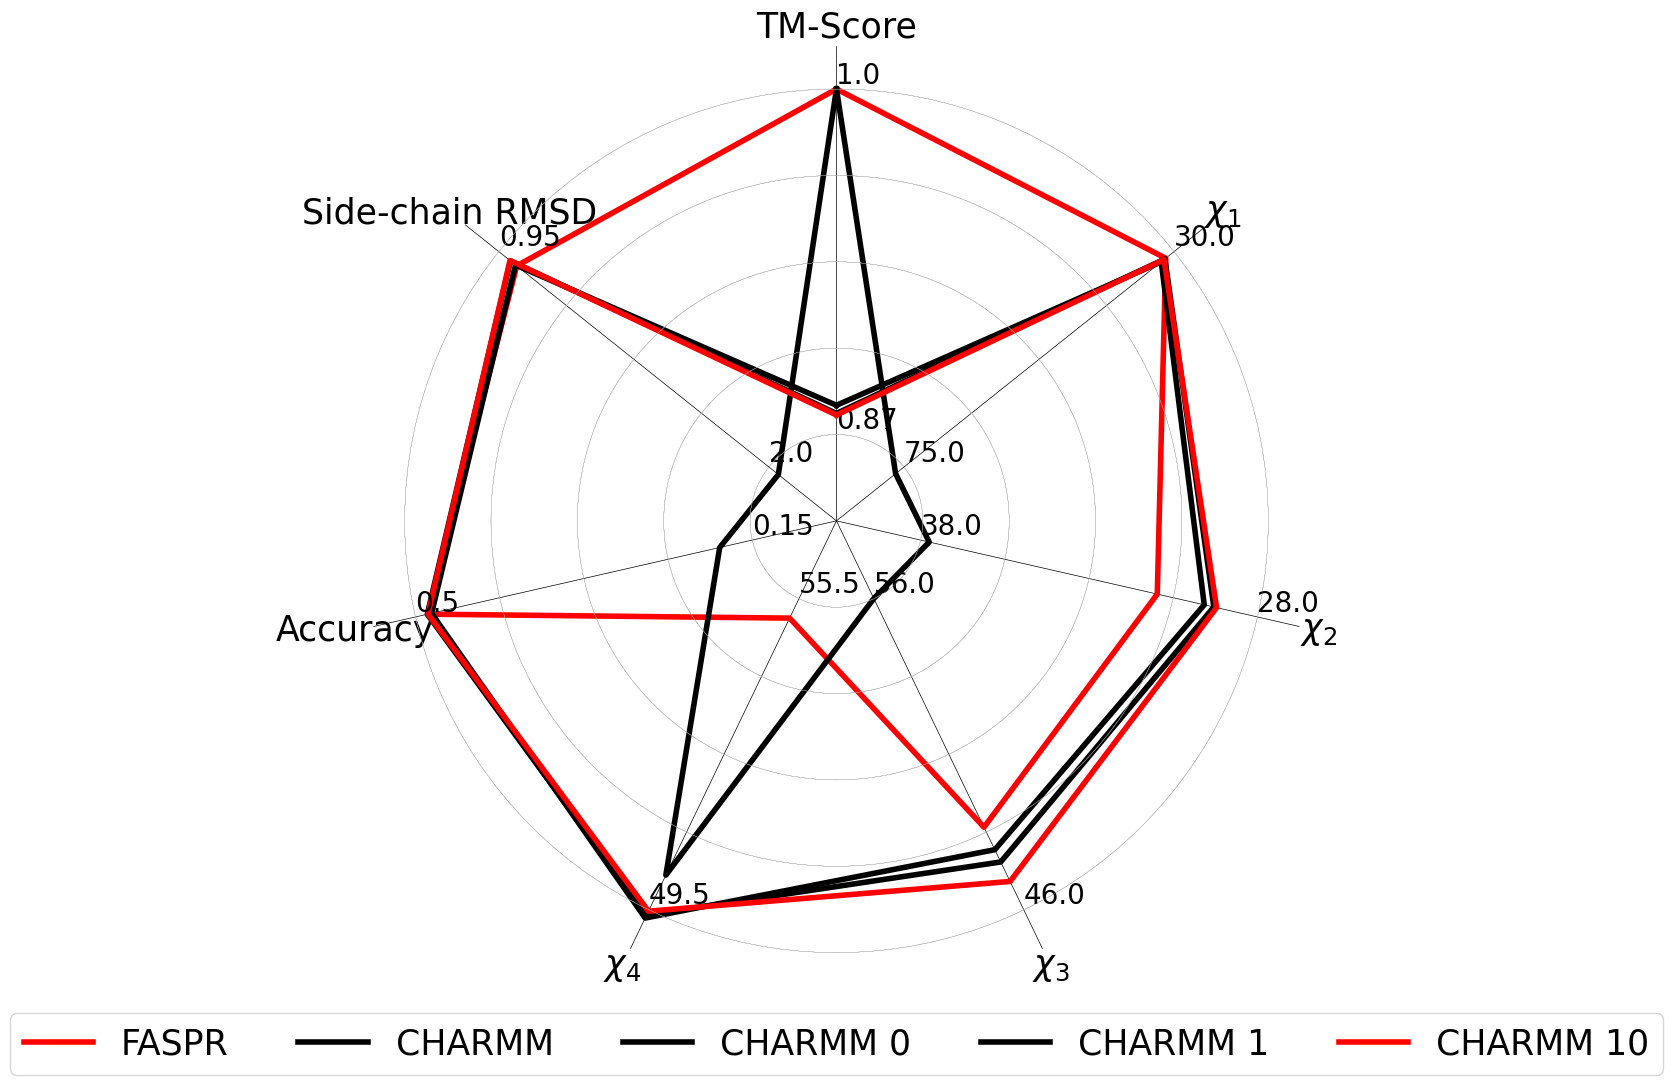

In [7]:
fig = plt.figure(figsize=(10, 10))
radar = Radar(fig, titles, labels)
for columnname in cut_df.columns:
    if "BB" in columnname or "FASPR " in columnname:
        continue
    values = (cut_df[columnname]-zeros)/(ends-zeros)
    radar.plot(values, label=columnname.replace("PSF","CHARMM"), color=columnname2colour[columnname])
radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=5)
fig = plt.gcf()
fig.savefig('figures/packing_psf.png',bbox_inches="tight", transparent=True)
fig.savefig('figures/packing_psf.svg',bbox_inches="tight", transparent=True)
fig.show()

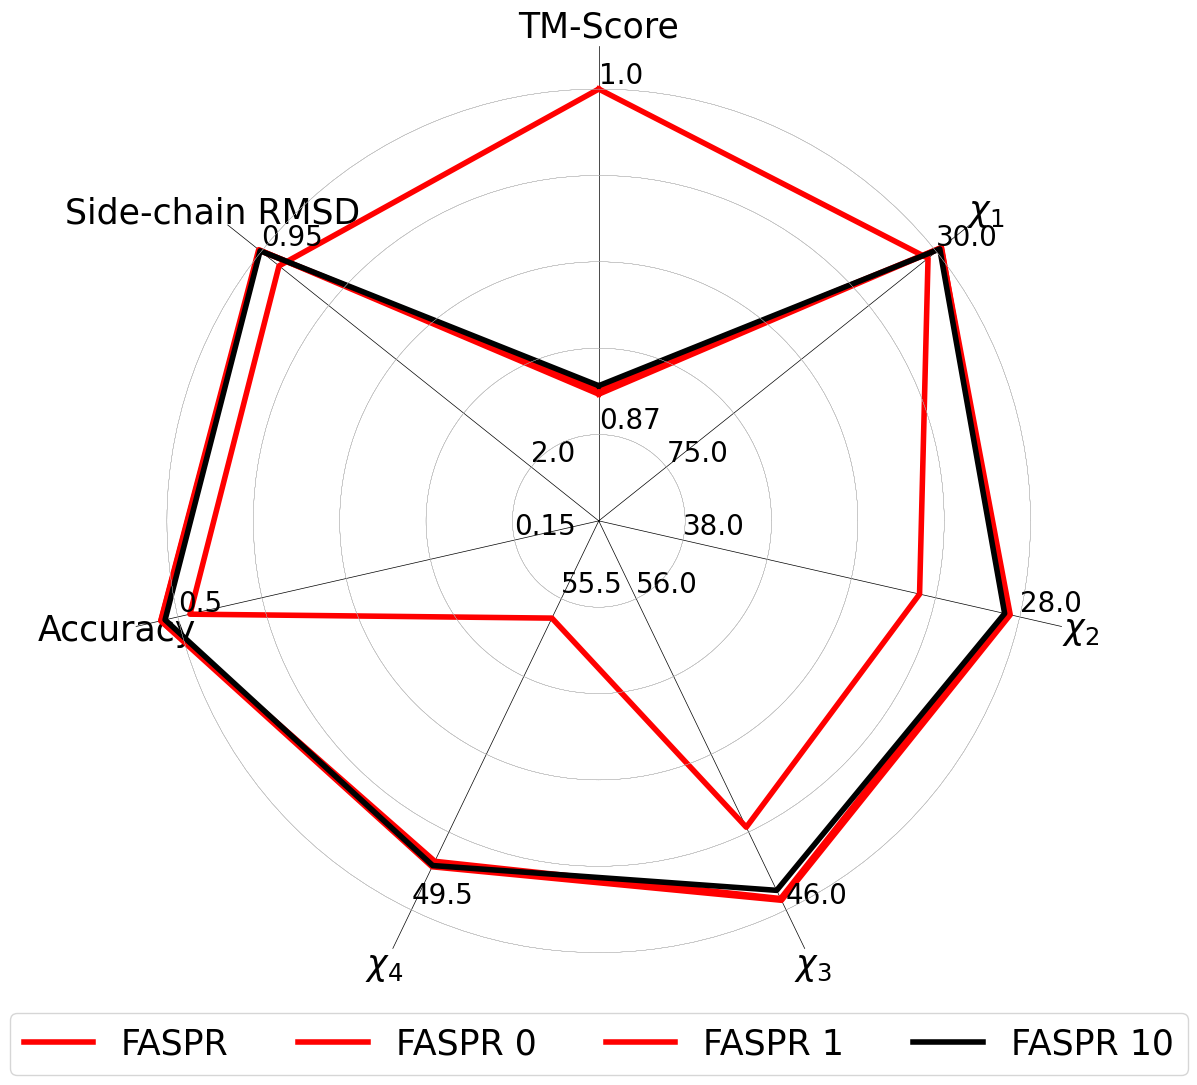

In [8]:
fig = plt.figure(figsize=(10, 10))
radar = Radar(fig, titles, labels)
for columnname in cut_df.columns:
    if "BB" in columnname or "PSF" in columnname:
        continue
    values = (cut_df[columnname]-zeros)/(ends-zeros)
    radar.plot(values, label=columnname.replace("PSF","CHARMM"), color=columnname2colour[columnname])
radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=4)
fig = plt.gcf()
fig.savefig('figures/packing_faspr.png',bbox_inches="tight", transparent=True)
fig.savefig('figures/packing_faspr.svg',bbox_inches="tight", transparent=True)
fig.show()